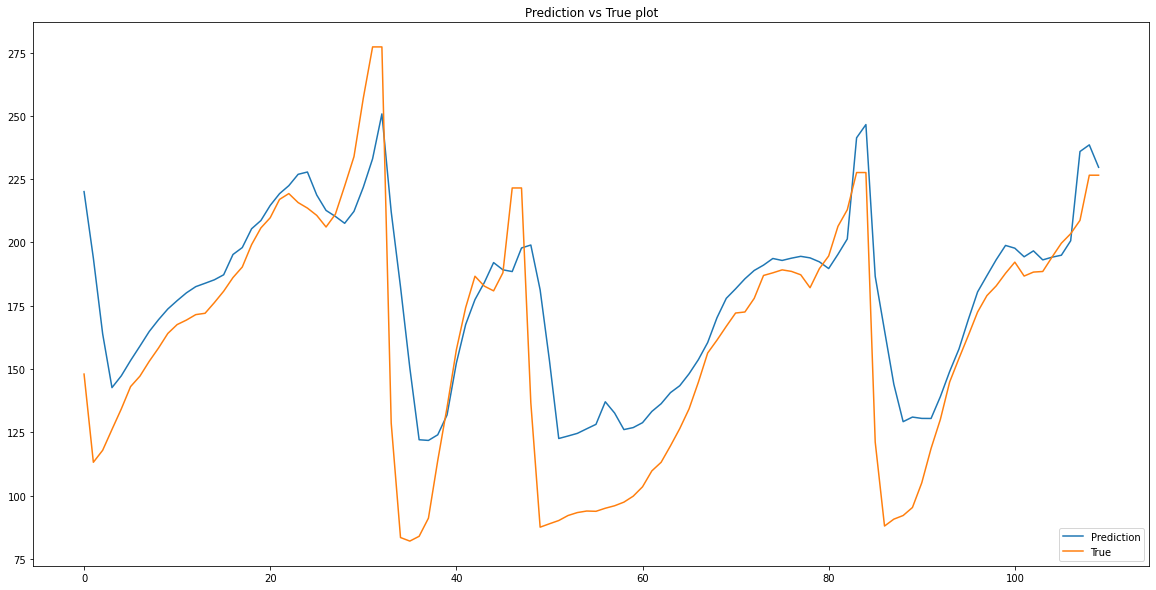

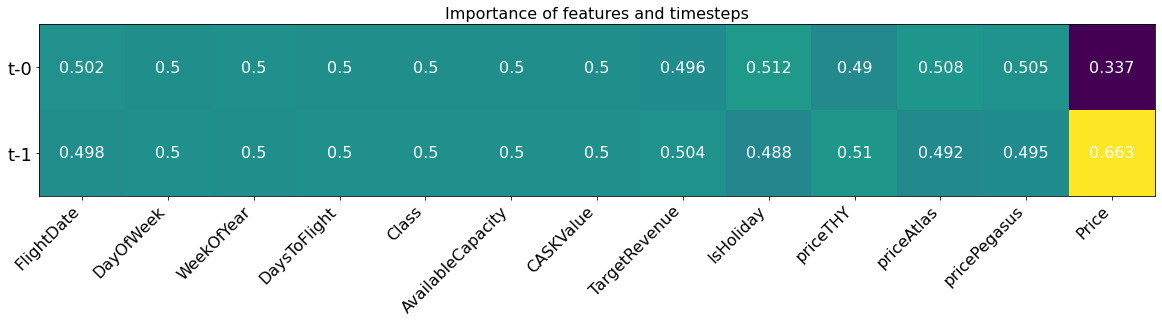

rmse     :  29.530418101708598
a10      :  0.6454545454545455
a20      :  0.7363636363636363
r2       :  0.21064663748871115
rmspe    :  28.647372126579285
Accuracy :  83.0 %.


In [2]:
import sys

import pandas as pd
import numpy as np
import math

import matplotlib
matplotlib.use('Agg')
from matplotlib.pyplot import plot, savefig, figure
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

class IMVTensorLSTM(torch.jit.ScriptModule):
    
    __constants__ = ["n_units", "input_dim"]
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        torch.manual_seed(0)
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_i = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_f = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_o = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_i = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_f = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_o = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_i = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_f = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_o = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    
    @torch.jit.script_method
    def forward(self, x):
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            # eq 1
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            # eq 5
            i_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_i) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_i) + self.b_i)
            f_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_f) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_f) + self.b_f)
            o_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_o) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_o) + self.b_o)
            # eq 6
            c_tilda_t = c_tilda_t*f_tilda_t + i_tilda_t*j_tilda_t
            # eq 7
            h_tilda_t = (o_tilda_t*torch.tanh(c_tilda_t))
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        # eq 8
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n) +self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)
        
        return mean, alphas, betas

def findaIndex(a,b,idx):
  cnt = 0
  for i in range(len(a)):
    if abs(a[i]/b[i]-1) < idx/100:
      cnt +=1
  return cnt / len(a)

def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100   
from pandas import read_csv

hyper_parameters = pd.read_csv('../data/hyper_parameters.csv', header=0)

index_column = int(hyper_parameters["index_column"].iloc[0])
target_column = int(hyper_parameters["target_column"].iloc[0])
#training_percent = int(hyper_parameters["training_percent"].iloc[0])
#validation_percent = int(hyper_parameters["validation_percent"].iloc[0])
look_back = int(hyper_parameters["look_back"].iloc[0])
prediction_horizon = int(hyper_parameters["prediction_horizon"].iloc[0])
output_dimension = int(hyper_parameters["output_dimension"].iloc[0])
number_of_neurons = int(hyper_parameters["number_of_neurons"].iloc[0])
learning_rate = float(hyper_parameters["learning_rate"].iloc[0])
optimizer_step_size = int(hyper_parameters["optimizer_step_size"].iloc[0])
gamma = int(hyper_parameters["gamma"].iloc[0])
epochs = int(hyper_parameters["epochs"].iloc[0])
patience = int(hyper_parameters["patience"].iloc[0])
plot_predictions_tail = int(hyper_parameters["plot_predictions_tail"].iloc[0])

if int(hyper_parameters["training_percent"].iloc[0]) + int(hyper_parameters["validation_percent"].iloc[0]) > 99:
    print("Sum of training and validation percent can not be more than 99.")
    sys.exit()

data = pd.read_csv("../data/"+hyper_parameters["data_file"].iloc[0].replace('\xa0', ' '), header=0)
cols = data.columns.to_list(); 
target = cols[target_column]

#df.sort_values(by=['col1'])
data.sort_values(by=[cols[index_column]])

#numberofbatches = len(np.unique(data.values[:,index_column]))

# set training, validation and test partitions
train_size_end = data[data[cols[index_column]]==data.values[int(len(data) * int(hyper_parameters["training_percent"].iloc[0]) / 100),index_column]].index.values[0]
val_size_end = data[data[cols[index_column]]==data.values[int(len(data) * (int(hyper_parameters["training_percent"].iloc[0]) + int(hyper_parameters["validation_percent"].iloc[0])) / 100),index_column]].index.values[0]

#print(train_size_end, val_size_end)
datatest = data.iloc[val_size_end:,]

flightDatesTrain = np.unique(data.values[:train_size_end,index_column])
flightDatesVal = np.unique(data.values[train_size_end+1:val_size_end,index_column])
flightDatesTest = np.unique(datatest.values[:,index_column])

X = np.zeros((len(data), look_back, len(cols)))
for i, name in enumerate(cols):
    for j in range(look_back):
        X[:, j, i] = data[name].shift(look_back - j - 1).fillna(method="bfill")

xmin, ymin = X.min(axis=0), data[target].min(axis=0)
xmax, ymax = X.max(axis=0), data[target].max(axis=0)

def adjustdata(subdata):
    X = np.zeros((len(subdata), look_back, len(cols)))
    Y = np.zeros((len(subdata), 1))

    for i, name in enumerate(cols):
        for j in range(look_back):
            X[:, j, i] = subdata[name].shift(look_back - j - 1).fillna(method="bfill")
    Y = subdata[target].shift(-prediction_horizon).fillna(method='ffill')

    retx = X[look_back:len(X)]
    rety = Y[look_back:len(X)]

    retx = (retx - xmin)/(xmax - xmin + 1e-9)
    rety = (rety - ymin)/(ymax - ymin + 1e-9)
    
    return retx, rety

###########################################################################################

model = IMVTensorLSTM(data.shape[1], output_dimension, number_of_neurons).cuda()
opt = torch.optim.Adam(model.parameters(), learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, optimizer_step_size, gamma)

from sklearn.metrics import mean_squared_error, mean_absolute_error

loss = nn.MSELoss()
min_val_loss = 9999

from torch import autograd
counter = 0
res = np.zeros((epochs,len(flightDatesTrain)))
for i in range(epochs):
    mse_train = 0
    for t_i in range(0, len(flightDatesTrain)):
        mask=(flightDatesTrain[t_i] == data.values[:,index_column])
        subdata = pd.DataFrame(data.values[mask,:], columns=cols)
        batch_x, batch_y = adjustdata(subdata)               

        batch_x = torch.Tensor(batch_x).cuda()
        batch_y = torch.Tensor(batch_y.values).cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()

        res[i][t_i] = mse_train

    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for t_i2 in range(0, len(flightDatesVal)):
            mask=(flightDatesVal[t_i2] == data.values[:,index_column])
            subdata = pd.DataFrame(data.values[mask,:], columns=cols)
            batch_x, batch_y = adjustdata(subdata)               

            batch_x = torch.Tensor(batch_x).cuda()
            batch_y = torch.Tensor(batch_y.values).cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        wghts= model.state_dict()
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
              break

    epoch_scheduler.step()

model.load_state_dict = wghts

with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []

    for t_i2 in range(0, len(flightDatesTest)):
        mask=(flightDatesTest[t_i2] == datatest.values[:,index_column])
        subdata = pd.DataFrame(datatest.values[mask,:], columns=cols)
        if len(subdata) > 1 :
          batch_x, batch_y = adjustdata(subdata)               
          batch_x = torch.Tensor(batch_x).cuda()
          batch_y = torch.Tensor(batch_y.values).cuda()
          output, a, b = model(batch_x)
          output = output.squeeze(1)
          preds.append(output.detach().cpu().numpy())
          true.append(batch_y.detach().cpu().numpy())
          alphas.append(a.detach().cpu().numpy())
          betas.append(b.detach().cpu().numpy())
          mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

preds = preds*(ymax - ymin) + ymin
true = true*(ymax - ymin) + ymin

mse = mean_squared_error(true, preds)

plt.figure(figsize=(20, 10))
plt.title("Prediction vs True plot")
plt.plot(preds[-1 * plot_predictions_tail:], label = "Prediction")
plt.plot(true[-1 * plot_predictions_tail:], label = "True")
plt.legend(["Prediction", "True"], loc ="lower right")
plt.show()
savefig('../results/predictionVStrue.png')

alphas = alphas.mean(axis=0)
alphas = alphas[..., index_column]

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(alphas)
ax.set_yticks(np.arange(look_back))
ax.set_xticks(np.arange(len(cols)))
ax.set_yticklabels(["t-"+str(i) for i in np.arange(look_back)], fontsize=18)
ax.set_xticklabels(cols, rotation = 45, ha="right", fontsize=16)

for i2 in range(look_back):
    for j2 in range(len(cols)):
        text = ax.text(j2, i2, round(alphas[i2, j2], 3), ha="center", va="center", color="w", fontsize=16)
ax.set_title("Importance of features and timesteps", fontsize=16)
plt.show()
savefig('../results/heatmap.png')

s = pd.Series(preds[-1 * plot_predictions_tail:])
s.to_csv("../results/output.csv")

print("rmse     : ", math.sqrt(mean_squared_error(preds, true)))
print("a10      : ", findaIndex(preds,true,10))
print("a20      : ", findaIndex(preds,true,20))
print("r2       : ", r2_score(preds,true))
print("rmspe    : ", rmspe(true, preds))

# Calculate mean absolute percentage error (MAPE)
errors = abs(preds - true)
mape = 100 * (errors / true)

## Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy : ', round(accuracy, 2), '%.')